In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
%matplotlib inline

traindata = pd.read_csv("train_values.csv",sep=',')
traindata.columns[traindata.isna().any()]
data=traindata
data.drop(['building_id'], axis=1, inplace=True)
trainlabels = pd.read_csv("train_labels.csv",sep=',')
trainout=trainlabels
trainout.drop(['building_id'], axis=1, inplace=True)
testvalues = pd.read_csv("test_values.csv",sep=',')
testdata=testvalues
testdata.drop(['building_id'], axis=1, inplace=True)

In [2]:
cleanup_letters = {"land_surface_condition": {"n": 1, "o": 2, "t":3},
                "foundation_type": {"h": 1, "i": 2, "r": 3, "u": 4, "w": 5},               
                "roof_type": {"n": 1, "q": 2, "x": 3},
                "ground_floor_type": {"f": 1, "m": 2, "v": 3, "x": 4, "z": 5},
                "other_floor_type": {"j": 1, "q": 2, "s": 3, "x": 4},
                "position": {"j": 1, "o": 2, "s": 3, "t": 4},
                "plan_configuration": {"a": 1, "c": 2, "d": 3, "f": 4, "m": 5, "n": 6, "o": 7, "q": 8, "s": 9, "u":10},
                "legal_ownership_status": {"a": 1, "r": 2, "v": 3, "w": 4}             
               }
data.replace(cleanup_letters, inplace=True)
testdata.replace(cleanup_letters, inplace=True)
a = list(data)
del a[-1]
x = data[a].values
y = trainout['damage_grade'].values

In [3]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [4]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((208480, 37), (208480,), (52121, 37), (52121,))

In [5]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

error_list = list()

# Iterate through all of the possibilities for number of estimators
tree_list = [15, 50, 100, 200, 400]
for n_trees in tree_list:
    
    # Initialize the gradient boost classifier
    GBC = GradientBoostingClassifier(n_estimators=n_trees, subsample=0.5, max_features=25, random_state=42)

    # Fit the model
    GBC.fit(x_train, y_train)
    y_pred = GBC.predict(x_test)

    # Get the error
    error = 1. - accuracy_score(y_test, y_pred)
    
    # Store it
    error_list.append(pd.Series({'n_trees': n_trees, 'error': error}))

error_df = pd.concat(error_list, axis=1).T.set_index('n_trees')

error_df

,error
n_trees,
15.0,0.361908
50.0,0.336448
100.0,0.318164
200.0,0.305827
400.0,0.292953


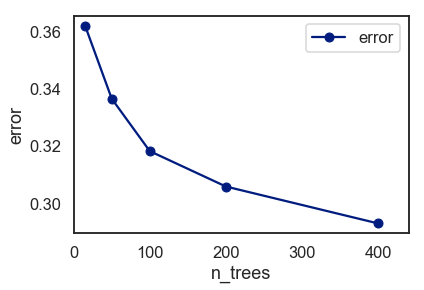

In [6]:
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

# Create the plot
ax = error_df.plot(marker='o')

# Set parameters
ax.set(xlabel='n_trees', ylabel='error')
ax.set_xlim(0, max(error_df.index)*1.1);

In [7]:
##grid search

In [8]:
from sklearn.model_selection import GridSearchCV

# The parameters to be fit--only n_estimators and learning rate
# have been varied here for simplicity
param_grid = {'n_estimators': [200, 400],'learning_rate': [0.1, 0.01]}

# The grid search object
GV_GBC = GridSearchCV(GradientBoostingClassifier(subsample=0.5,max_features=25,random_state=42),param_grid=param_grid, scoring='accuracy',n_jobs=-1)

# Do the grid search
GV_GBC = GV_GBC.fit(x_train, y_train)

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [9]:
# The best model
GV_GBC.best_estimator_  # this model is working best for  learning_rate=0.1 and n_estimators=400 

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=25, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=400,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=0.5, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [10]:
"""classification report"""
from sklearn.metrics import classification_report

y_pred = GV_GBC.predict(x_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           1       0.41      0.70      0.51      3006
           2       0.85      0.70      0.77     36075
           3       0.55      0.73      0.63     13040

   micro avg       0.71      0.71      0.71     52121
   macro avg       0.60      0.71      0.64     52121
weighted avg       0.75      0.71      0.72     52121



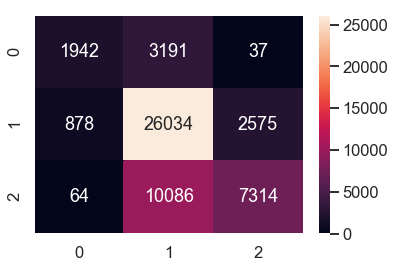

In [12]:
from sklearn.metrics import confusion_matrix

sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

In [ ]:
#adaboost

In [11]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ABC = AdaBoostClassifier(DecisionTreeClassifier(max_features=4))

param_grid = {'n_estimators': [100, 150, 200],'learning_rate': [0.01, 0.001]}

GV_ABC = GridSearchCV(ABC,param_grid=param_grid,scoring='accuracy',n_jobs=-1)

GV_ABC = GV_ABC.fit(x_train, y_train)

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [12]:
# The best model
GV_ABC.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.01, n_estimators=200, random_state=None)

In [13]:
""" again classification report"""
y_pred = GV_ABC.predict(x_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           1       0.47      0.66      0.55      3638
           2       0.83      0.72      0.77     34010
           3       0.59      0.71      0.64     14473

   micro avg       0.71      0.71      0.71     52121
   macro avg       0.63      0.70      0.65     52121
weighted avg       0.73      0.71      0.72     52121



In [14]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

NameError: name 'confusion_matrix' is not defined

In [15]:
# Suppress warnings about too few trees from the early models

import warnings # we can use this anywhere to ignore wargnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [16]:
from sklearn.linear_model import LogisticRegressionCV

# L2 regularized logistic regression
LR_L2 = LogisticRegressionCV(Cs=5, cv=4, penalty='l2').fit(x_train, y_train)

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [17]:
"""classfication report """
y_pred = LR_L2.predict(x_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           1       0.15      0.55      0.23      1366
           2       0.97      0.57      0.72     50154
           3       0.01      0.43      0.03       601

   micro avg       0.57      0.57      0.57     52121
   macro avg       0.38      0.52      0.33     52121
weighted avg       0.94      0.57      0.70     52121



In [18]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

NameError: name 'confusion_matrix' is not defined

In [23]:
from sklearn.ensemble import VotingClassifier

# The combined model--logistic regression and gradient boosted trees
estimators = [('LR_L2', LR_L2), ('GBC', GV_GBC)]

# Though it wasn't done here, it is often desirable to train 
# this model using an additional hold-out data set and/or with cross validation
VC = VotingClassifier(estimators, voting='soft')
VC = VC.fit(x_train, y_train)

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [24]:
y_pred = VC.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.72      0.32      0.44      5170
           2       0.66      0.91      0.77     29487
           3       0.79      0.42      0.54     17464

   micro avg       0.69      0.69      0.69     52121
   macro avg       0.72      0.55      0.58     52121
weighted avg       0.71      0.69      0.66     52121



In [25]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

NameError: name 'confusion_matrix' is not defined

In [26]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
err_list=[]
for n_tree in [25, 50, 100, 200, 400]:
    gbc=GradientBoostingClassifier(n_estimators=n_tree,max_features=4,warm_start=True)
    gbc.fit(x_train,y_train)
    y_pred=gbc.predict(x_test)
    err=1-accuracy_score(y_pred,y_test)
    err_list.append(err)
err_list

[0.37689223153815166,
 0.3724986090059669,
 0.34512000920933983,
 0.33456764068225864,
 0.3224995683121966]

In [27]:
from sklearn.model_selection import GridSearchCV
gbc=GradientBoostingClassifier(max_features=4,warm_start=True)
param_grid={'learning_rate':[0.1, 0.01, 0.001],'max_features':[1,2,3,4]}
gsc=GridSearchCV(gbc,param_grid=param_grid,scoring='accuracy')
gsc.fit(x_train,y_train)

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=4, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_...       subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=True),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [0.1, 0.01, 0.001], 'max_features': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [28]:
gsc.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=4, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=True)

In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.68      0.38      0.49      5170
           2       0.66      0.88      0.76     29487
           3       0.74      0.42      0.53     17464

   micro avg       0.68      0.68      0.68     52121
   macro avg       0.69      0.56      0.59     52121
weighted avg       0.69      0.68      0.66     52121



In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ABC = AdaBoostClassifier(DecisionTreeClassifier(max_features=4))

param_grid = {'n_estimators': [100, 150, 200],'learning_rate': [0.01, 0.001]}

GV_ABC = GridSearchCV(ABC, param_grid=param_grid,  scoring='accuracy', n_jobs=-1)

GV_ABC = GV_ABC.fit(x_train, y_train)


In [ ]:
GV_ABC.best_estimator_

In [ ]:
y_pred = GV_ABC.predict(X_test)
print(classification_report(y_pred, y_test))

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

# L2 regularized logistic regression
LR_L2 = LogisticRegressionCV(Cs=5, cv=4, penalty='l2').fit(X_train, y_train)

In [ ]:
y_pred = LR_L2.predict(X_test)
print(classification_report(y_pred, y_test))

In [ ]:
from sklearn.ensemble import VotingClassifier

# The combined model--logistic regression and gradient boosted trees
estimators = [('LR_L2', LR_L2), ('GBC', GV_GBC)]

# Though it wasn't done here, it is often desirable to train 
# this model using an additional hold-out data set and/or with cross validation
VC = VotingClassifier(estimators, voting='soft')
VC = VC.fit(X_train, y_train)

In [ ]:
y_pred = VC.predict(X_test)
print(classification_report(y_test, y_pred))